## Базовые блоки

In [ ]:
import tensorflow.compat.v1 as tf
tf.disable_eager_execution()
tf.disable_v2_behavior()
import numpy as np

sess = tf.InteractiveSession()

def conv_layer(
        input_tensor,
        output_channels,
        name='conv',
        kernel_size=(3, 3),
        strides=(1, 1),
        padding='SAME'
    ):
    with tf.variable_scope(name, reuse=tf.AUTO_REUSE):
        input_shape = input_tensor.get_shape().as_list()
        
        input_channels = input_shape[-1]
        
        # get variable weights with name weights

        weights = tf.get_variable('weights', shape=[kernel_size[0], kernel_size[1], input_channels, output_channels])
        
        # get variable bias with name bias
        bias = tf.get_variable('bias', shape=[output_channels])
        
        conv = tf.nn.conv2d(
            input=input_tensor,
            filter=weights,
            strides=strides,
            padding=padding,
            name='conv'
        )
        
        output = tf.nn.bias_add(conv, bias, name='output')
    return output

In [ ]:
def max_pool(
    input_tensor,
    kernel_size=(2, 2),
    strides=(2, 2),
    padding='SAME',
    name='pool'
):
    with tf.variable_scope(name, reuse=tf.AUTO_REUSE):
        output = tf.nn.max_pool2d(input_tensor, ksize=kernel_size, strides=strides, padding=padding, name='pool')
    return output

In [ ]:
def avg_pool(
    input_tensor,
    kernel_size=(2, 2),
    strides=(2, 2),
    padding='SAME',
    name='pool'
):
    with tf.variable_scope(name, reuse=tf.AUTO_REUSE):
        output = tf.nn.avg_pool2d(input_tensor, ksize=kernel_size, strides=strides, padding=padding, name='pool')
    return output

In [ ]:
def flatten(
    input_tensor,
    name='flatten'
):
    with tf.variable_scope(name, reuse=tf.AUTO_REUSE):
        shape = input_tensor.get_shape().as_list()[1:]
        num_elements = np.prod(shape)
        return tf.reshape(input_tensor, [-1, num_elements], name='reshape')

In [ ]:
def dense(
    input_tensor,
    output_neurons,
    name='fc'
):
    with tf.variable_scope(name, reuse=tf.AUTO_REUSE):
        input_neurons = input_tensor.get_shape().as_list()[1]
        
        weights = tf.get_variable(
            name='weights',
            shape=[input_neurons, output_neurons]
        )
        
        bias = tf.get_variable(
            name='bias',
            shape=[output_neurons]
        )
        
        product = tf.matmul(input_tensor, weights, name='product')
        
        output = tf.nn.bias_add(product, bias, name='output')
    return output

In [ ]:
def fc_with_relu(
    input_tensor,
    output_neurons,
    name='fc_with_relu'
):
    with tf.variable_scope(name, reuse=tf.AUTO_REUSE):
        fc = dense(input_tensor, 
                   output_neurons, 
                   name='fc'
        )
        relu = tf.nn.relu(fc, name='relu')

    return relu

In [ ]:
def conv_block(
    x,
    output_channels,
    name,
    strides=(1, 1),
    kernel_size=(3, 3),
    padding='SAME'
):
    with tf.variable_scope(name, reuse=tf.AUTO_REUSE):
        conv_out = conv_layer(
            x, output_channels, name, kernel_size, strides, padding
        )
        activation = tf.nn.relu(conv_out) # Add ReLU activation
    return activation

In [ ]:
def define_metrics(scope_name, variables: dict):
    with tf.name_scope(f'{scope_name}train/'):
        accuracy_train, accuracy_train_op = tf.metrics.accuracy(
            labels=variables['target'],
            predictions=variables['predictions']
        )
        loss_train, loss_train_op = tf.metrics.mean(
            values=variables['loss'],
            name='loss'
        )
    with tf.name_scope(f'{scope_name}val/'):
        accuracy_val, accuracy_val_op = tf.metrics.accuracy(
            labels=variables['target'],
            predictions=variables['predictions']
        )
        loss_val, loss_val_op = tf.metrics.mean(
            values=variables['loss'],
            name='loss'
        )
    
    return {
        'train_acc': accuracy_train,
        'train_update_acc': accuracy_train_op,
        'val_acc': accuracy_val,
        'val_update_acc': accuracy_val_op,
        'train_loss': loss_train,
        'val_loss': loss_val,
        'train_update_loss': loss_train_op,
        'val_update_loss': loss_val_op
    }

In [ ]:
def reset_metrics(scope):
    stream_variables = [v for v in tf.local_variables() if scope in v.name]
    sess.run(tf.variables_initializer(stream_variables))

In [ ]:
def iterate_batches(X, y, batch_size, shuffle=True):
    assert len(X) == len(y)
    
    indices = np.arange(len(X))
    if shuffle:
        np.random.shuffle(indices)
    
    for index in range(0, len(X), batch_size):
        yield X[indices[index:index + batch_size]], y[indices[index:index + batch_size]]

In [ ]:
def batch_norm(input_tensor, is_training, momentum=0.9, name='batch_norm'):
    with tf.variable_scope(name, reuse=tf.AUTO_REUSE):
        shapes = input_tensor.get_shape().as_list()
        
        gamma = tf.get_variable('gamma', shape=shapes[1:], initializer=tf.ones_initializer())
        beta = tf.get_variable('beta', shape=shapes[1:], initializer=tf.zeros_initializer())
        
        moving_mean = tf.get_variable('moving_mean', shape=shapes[1:], initializer=tf.zeros_initializer())
        moving_var = tf.get_variable('moving_var', shape=shapes[1:], initializer=tf.ones_initializer())
        
        
        updates = []
        
        def training_fn():
            current_mean, current_var = tf.nn.moments(input_tensor, axes=0)
            x_norm = (input_tensor - current_mean) / tf.sqrt(current_var + 1e-5)

            # calculate moving average with variable mean and momentum

            updates.append(
                tf.assign(moving_mean, momentum * moving_mean + (1 - momentum) * current_mean)
            )

            # calculate moving average with variable current_var and momentum
            updates.append(
                tf.assign(moving_var, momentum * moving_var + (1 - momentum) * current_var)
            )
            
            return x_norm, updates
        
        def test_fn():
            x_norm = (input_tensor - moving_mean) / tf.sqrt(moving_var + 1e-5)
            return x_norm, updates
        
        
        x_norm, updates = tf.cond(
            is_training,
            true_fn=training_fn,
            false_fn=test_fn
        )
        
        return gamma * x_norm + beta, updates
            

In [ ]:
def conv_block_with_bn(
    x,
    output_channels,
    is_training,
    name,
    kernel_size=(3, 3),
    strides=(1, 1),
    padding='SAME',
    bn_momentum=0.9
):
    with tf.variable_scope(name, reuse=tf.AUTO_REUSE):
        conv_out = conv_layer(
            x, output_channels,
            kernel_size=kernel_size,
            padding=padding,
            strides=strides
        )
        bn_out, updates = batch_norm(conv_out, is_training, momentum=bn_momentum)
        activation = tf.nn.relu(bn_out, name='relu')
    return activation, updates

In [ ]:
def dropout(input_tensor, rate, name='dropout'):
    return tf.nn.dropout(input_tensor, rate=rate, name=name)

## Загрузка данных

In [ ]:
import os

In [ ]:
!wget https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz

--2021-04-06 18:02:26--  https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.20.128, 74.125.142.128, 74.125.195.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.20.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 228813984 (218M) [application/x-compressed-tar]
Saving to: ‘flower_photos.tgz’

flower_photos.tgz   100%[===================>] 218.21M   135MB/s    in 1.6s    

2021-04-06 18:02:28 (135 MB/s) - ‘flower_photos.tgz’ saved [228813984/228813984]



In [ ]:
!tar -zxvf flower_photos.tgz

flower_photos/
flower_photos/roses/
flower_photos/roses/14810868100_87eb739f26_m.jpg
flower_photos/roses/1446090416_f0cad5fde4.jpg
flower_photos/roses/15319767030_e6c5602a77_m.jpg
flower_photos/roses/15032112248_30c5284e54_n.jpg
flower_photos/roses/7211616670_2d49ecb3a5_m.jpg
flower_photos/roses/15674450867_0ced942941_n.jpg
flower_photos/roses/17158274118_00ec99a23c.jpg
flower_photos/roses/14019883858_e5d2a0ec10_n.jpg
flower_photos/roses/8035908422_87220425d2_n.jpg
flower_photos/roses/14747962886_2bff6bb323_m.jpg
flower_photos/roses/4356781875_92c5cd93c0.jpg
flower_photos/roses/8524505546_b242bd4928_n.jpg
flower_photos/roses/9406573080_60eab9278e_n.jpg
flower_photos/roses/6039330368_c30ed224c4_m.jpg
flower_photos/roses/14414100710_753a36fce9.jpg
flower_photos/roses/3292434691_392071d702_n.jpg
flower_photos/roses/5273722065_c85d8543c2_m.jpg
flower_photos/roses/2215318403_06eb99176a.jpg
flower_photos/roses/172311368_49412f881b.jpg
flower_photos/roses/15255964454_0a64eb67fa.jpg
flower_pho

In [ ]:
DATASET_FOLDER = "flower_photos"

In [ ]:
class_names = [
    class_name for class_name in os.listdir(DATASET_FOLDER) if not class_name.endswith('txt')
]

In [ ]:
CLASS_INDICES = {
    class_name: index for index, class_name in enumerate(class_names)
}

In [ ]:
def get_flower_paths():
    paths = []
    indices = []
    
    for class_name in CLASS_INDICES.keys():
        class_folder = os.path.join(DATASET_FOLDER, class_name)
        
        for filename in sorted(os.listdir(class_folder)):
            if not filename.endswith('jpg'):
                continue
            path = os.path.join(class_folder, filename)
            indices.append(CLASS_INDICES[class_name])
            paths.append(path)
    
    return paths, indices

In [ ]:
flower_paths, flower_indices = get_flower_paths()

In [ ]:
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split

In [ ]:
flower_y = to_categorical(flower_indices)

In [ ]:
flower_paths_train, flower_paths_val, flower_y_train, flower_y_val = train_test_split(
    flower_paths,
    flower_y,
    random_state=42,
    test_size=0.2
)

In [ ]:
flower_paths_train = list(filter(lambda x: os.path.exists(x), flower_paths_train))

In [ ]:
flower_paths_val = list(filter(lambda x: os.path.exists(x), flower_paths_val))

In [ ]:
from tqdm import tqdm

In [ ]:
from joblib import Parallel, delayed

In [ ]:
import cv2
%matplotlib inline
import matplotlib.pyplot as plt

def process_image(filename):
    img = cv2.resize(cv2.imread(filename), (224, 224))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img / 127.5 - 1.0

In [ ]:
flowers_x_train = Parallel(n_jobs=8, verbose=10)(delayed(process_image)(path) for path in flower_paths_train)
flowers_x_train = np.concatenate([np.expand_dims(img, 0) for img in flowers_x_train])

[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.7s
[Parallel(n_jobs=8)]: Done   9 tasks      | elapsed:    0.8s
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    1.0s
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    1.1s
[Parallel(n_jobs=8)]: Batch computation too fast (0.1975s.) Setting batch_size=2.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    1.1s
[Parallel(n_jobs=8)]: Batch computation too fast (0.0835s.) Setting batch_size=4.
[Parallel(n_jobs=8)]: Done  46 tasks      | elapsed:    1.2s
[Parallel(n_jobs=8)]: Done  64 tasks      | elapsed:    1.3s
[Parallel(n_jobs=8)]: Batch computation too fast (0.1312s.) Setting batch_size=8.
[Parallel(n_jobs=8)]: Done 100 tasks      | elapsed:    1.5s
[Parallel(n_jobs=8)]: Done 160 tasks      | elapsed:    1.8s
[Parallel(n_jobs=8)]: Done 280 tasks      | elapsed:    2.2s
[Parallel(n_jobs=8)]: Done 400 tasks      | elapsed:    2.6s
[Paralle

In [ ]:
flowers_x_val = Parallel(n_jobs=8, verbose=10)(delayed(process_image)(path) for path in flower_paths_val)
flowers_x_val = np.concatenate([np.expand_dims(img, 0) for img in flowers_x_val])

[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Batch computation too fast (0.0204s.) Setting batch_size=2.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done   9 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Batch computation too fast (0.1414s.) Setting batch_size=4.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Batch computation too fast (0.1608s.) Setting batch_size=8.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Done 100 tasks      | elapsed:    0.5s
[Parallel(n_jobs=8)]: Done 176 tasks      | elapsed:    0.8s
[Parallel(n_jobs=8)]: Done 280 tasks      | elapsed:    1.2s
[Parallel(n_jobs=8)]: Done 384 tasks      | elapsed:    1.5s
[Parallel(n_jobs=8)]: Done 504 tasks      | elapsed:    1.9s
[Parallel(n_jobs=8)]: Done 624 tasks      | elapsed:    2.3s
[Paralle

## ResNet 

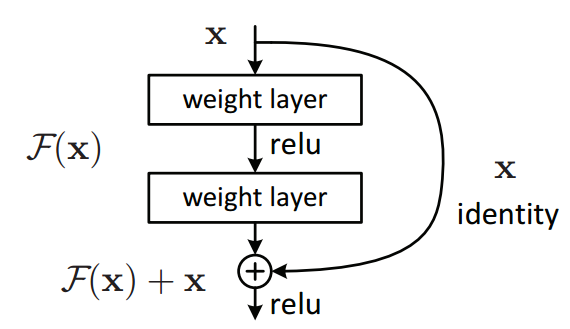

In [ ]:
from typing import List


def resnet_block(
    input_tensor,
    kernel_size,
    filters: List[int],
    is_training,
    strides=(2, 2),
    name='resnet_block'
):
    with tf.variable_scope(f'{name}', reuse=tf.AUTO_REUSE):
        # realize ResNet Block

        # Forward: conv + bn + relu + conv + bn
        # Skip connection: x
        # Result: ReLU of sum (Forward + Skip)
        
        conv1_out = conv_layer(
            input_tensor, output_channels=filters[0],
            kernel_size=kernel_size,
            strides=strides,
            name='conv1'
        )

        bn1_out, bn1_updates = batch_norm(conv1_out, is_training, name='bn1')

        relu1 = tf.nn.relu(bn1_out, name='relu1')

        conv2_out = conv_layer(
            relu1, output_channels=filters[1],
            kernel_size=kernel_size,
            strides=(1, 1),
            name='conv2'
        )

        bn2_out, bn2_updates = batch_norm(conv2_out, is_training, name='bn2')

        conv_shortcut_out = conv_layer(
            input_tensor, output_channels=filters[1],
            kernel_size=(1, 1),
            strides=strides,
            name='conv_shortcut'
        )

        bn_shortcut_out, bn_shortcut_updates = batch_norm(
            conv_shortcut_out, 
            is_training, 
            name='bn_shortcut'
        )

        relu2 = tf.nn.relu(bn2_out + bn_shortcut_out, name='relu2')
    
    # return tuple: (output, list of updates)
    return relu2, bn1_updates + bn2_updates + bn_shortcut_updates


In [ ]:
class BatchNormNetwork:
    
    def __init__(self):
        self.updates = []
        self.is_training = tf.placeholder(tf.bool, shape=[])
        
    def add_block(self, build_fn):
        output_tensor, output_updates = build_fn()
        
        self.updates.extend(output_updates)
        return output_tensor

In [ ]:
def global_average_pooling(input_tensor, name):
    return tf.reduce_mean(input_tensor, axis=(1, 2), name=name)

In [ ]:
class ResNet18(BatchNormNetwork):
    
    def __init__(self, input_tensor, num_classes):
        super().__init__()
        
        self.input_tensor = input_tensor
        self.num_classes = num_classes
        
        self.build_network()
    
        
    def build_network(self):
        with tf.variable_scope('resnet18', reuse=tf.AUTO_REUSE):

            self.block1 = self.add_block(
                lambda: conv_block_with_bn(
                    self.input_tensor,
                    output_channels=64,
                    is_training=self.is_training,
                    name='conv1',
                    strides=(2, 2)
                )
            )

            # build resnet blocks
            
            self.resnet_block1 = self.build_resnet_block(
                self.block1,
                output_filters=64,
                name='resnet_block1'
            )
            
            self.resnet_block2 = self.build_resnet_block(
                self.resnet_block1,
                output_filters=128,
                name='resnet_block2'
            )
            
            self.resnet_block3 = self.build_resnet_block(
                self.resnet_block2,
                output_filters=256,
                name='resnet_block3'
            )
            
            self.resnet_block4 = self.build_resnet_block(
                self.resnet_block3,
                output_filters=512,
                name='resnet_block4'
            )
            
            self.avg_pool = global_average_pooling(
                self.resnet_block4,
                name='global_avg_pool'
            )
            
            self.fc = dense(
                self.avg_pool,
                self.num_classes,
                name='fc'
            )
            
    def build_resnet_block(self, input_tensor, output_filters, name):
        with tf.variable_scope(name, reuse=tf.AUTO_REUSE):
            block1 = self.add_block(
                lambda: resnet_block(
                    input_tensor,
                    filters=[output_filters, output_filters],
                    name='branch1',
                    is_training=self.is_training,
                    strides=(2,2),
                    kernel_size=(3, 3)
                )
            )
            
            block2 = self.add_block(
                lambda: resnet_block(
                    block1,
                    filters=[output_filters, output_filters],
                    name='branch2',
                    is_training=self.is_training,
                    strides=(1, 1),
                    kernel_size=(3, 3)
                )
            )
        return block2
    
    def get_trainable_variables(self):
        return tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope='resnet18')
    
    def get_logits(self):
        return self.fc

In [ ]:
class LossMeter:
    def __init__(self, network, inputs, labels, name):
        self.network = network
        self.inputs = inputs
        self.labels = labels
        
        self.logits = self.network.get_logits()
        self.name = name
        
        with tf.variable_scope(name, reuse=tf.AUTO_REUSE):
            self.loss = tf.reduce_mean(
                tf.nn.sigmoid_cross_entropy_with_logits(
                    labels=self.labels,
                    logits=self.logits
                )
            )
            
            self.predictions = tf.argmax(self.logits, axis=1)
            self.target = tf.argmax(self.labels, axis=1)
            
            self.metrics = define_metrics(
                f'{name}/metrics/',
                variables={
                    'target': self.target,
                    'predictions': self.predictions,
                    'loss': self.loss
                }
            )
    
            self.optimizer = tf.train.AdamOptimizer(
                learning_rate=0.0001
            ).minimize(
                self.loss,
                var_list=self.network.get_trainable_variables()
            )
        
    def reset_metrics(self):
        reset_metrics(f'{self.name}/metrics/train')
        reset_metrics(f'{self.name}/metrics/val')

In [ ]:
tf.reset_default_graph()
sess = tf.InteractiveSession();

/usr/local/lib/python3.7/dist-packages/tensorflow/python/client/session.py:1761: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


In [ ]:
a = tf.placeholder_with_default(np.zeros((10, 224, 224, 3), dtype=np.float32), shape=(None, 224, 224, 3))
b = tf.placeholder_with_default(np.zeros((10, 5), dtype=np.float32), shape=(None, 5))

In [ ]:
net = ResNet18(a, num_classes=5)

In [ ]:
loss_meter = LossMeter(net, a, b, name='resnet18')

In [ ]:
def train_ResNet(X_train, X_val, y_train, y_val):

    sess.run(tf.global_variables_initializer())
    sess.run(tf.local_variables_initializer())

    for epoch_num in range(20):
        loss_meter.reset_metrics()
        for X_batch, y_batch in iterate_batches(X_train, y_train, 64):
            _, _, _, _ = sess.run([
                loss_meter.optimizer,
                loss_meter.metrics['train_update_acc'],
                loss_meter.metrics['train_update_loss'],
                net.updates
            ], feed_dict={
                loss_meter.inputs: X_batch,
                loss_meter.labels: y_batch,
                net.is_training: True
            })
            
            loss_value, accuracy = sess.run([
                loss_meter.metrics['train_acc'],
                loss_meter.metrics['train_loss']
            ])
            # print(loss_value, accuracy)
        
        print(f'Epoch {epoch_num + 1} train [acc, loss]:', sess.run([
            loss_meter.metrics['train_acc'],
            loss_meter.metrics['train_loss']
        ]))
        
        for X_batch, y_batch in iterate_batches(X_val, y_val, 64, shuffle=False):
            _, _ = sess.run([
                loss_meter.metrics['val_update_acc'],
                loss_meter.metrics['val_update_loss']
            ], feed_dict = {
                loss_meter.inputs: X_batch,
                loss_meter.labels: y_batch,
                net.is_training: False
            })
        print(
            f'Epoch {epoch_num + 1} val [acc, loss]:',
            sess.run([
                loss_meter.metrics['val_acc'], 
                loss_meter.metrics['val_loss']
            ])
        )

In [ ]:
train_ResNet(flowers_x_train, flowers_x_val, flower_y_train, flower_y_val)

Epoch 1 train [acc, loss]: [0.47207084, 0.4578907]
Epoch 1 val [acc, loss]: [0.35967302, 0.5330491]
Epoch 2 train [acc, loss]: [0.6032016, 0.34877205]
Epoch 2 val [acc, loss]: [0.592643, 0.35108975]
Epoch 3 train [acc, loss]: [0.6474796, 0.30852813]
Epoch 3 val [acc, loss]: [0.5476839, 0.41219142]
Epoch 4 train [acc, loss]: [0.71934605, 0.26777807]
Epoch 4 val [acc, loss]: [0.52724797, 0.5830083]
Epoch 5 train [acc, loss]: [0.77520436, 0.22705342]
Epoch 5 val [acc, loss]: [0.5817439, 0.41160485]
Epoch 6 train [acc, loss]: [0.82697546, 0.18306962]
Epoch 6 val [acc, loss]: [0.5681199, 0.61097234]
Epoch 7 train [acc, loss]: [0.8756812, 0.13662411]
Epoch 7 val [acc, loss]: [0.59945506, 0.44135228]
Epoch 8 train [acc, loss]: [0.9237057, 0.095907375]
Epoch 8 val [acc, loss]: [0.63623977, 0.42152977]
Epoch 9 train [acc, loss]: [0.9420981, 0.07472596]
Epoch 9 val [acc, loss]: [0.6076294, 0.46144548]
Epoch 10 train [acc, loss]: [0.95333785, 0.06295084]
Epoch 10 val [acc, loss]: [0.58991826, 0.5

## Inception

In [ ]:
from collections import namedtuple

FilterSpec = namedtuple('FilterSpec', [
    'filters_1x1',
    'filters_3x3',
    'filters_3x3_reduce',
    'filters_5x5',
    'filters_5x5_reduce',
    'filters_pool'
])


class InceptionV1Network:
    def __init__(self, input_tensor, num_classes):
        self.input_tensor = input_tensor
        
        self.num_classes = num_classes
        
        self.build_network()
        
    def build_network(self):
        with tf.variable_scope('inception_v1', reuse=tf.AUTO_REUSE):
            self.conv1 = conv_block(
                self.input_tensor,
                output_channels=64,
                name='conv1',
                kernel_size=(7, 7),
                strides=(2, 2)
            )
            
            self.pool1 = max_pool(
                self.conv1,
                kernel_size=(3, 3),
                strides=(2, 2),
                name='pool1'
            )
            
            self.conv2a = conv_block(
                self.pool1,
                output_channels=64,
                kernel_size=(3, 3),
                strides=(1, 1),
                name='conv2a'
            )
            
            self.conv2b = conv_block(
                self.conv2a,
                output_channels=192,
                kernel_size=(3, 3),
                strides=(1, 1),
                name='conv2b'
            )
            
            self.pool2 = max_pool(
                self.conv2b,
                kernel_size=(3, 3),
                strides=(2, 2),
                name='pool2'
            )
            
            self.block3a = self.inception_block(
                self.pool2,
                FilterSpec(
                    filters_1x1=64,
                    filters_3x3_reduce=96,
                    filters_3x3=128,
                    filters_5x5_reduce=16,
                    filters_5x5=32,
                    filters_pool=32,
                ),
                name='block3a'
            )
            
            self.block3b = self.inception_block(
                self.block3a,
                FilterSpec(
                    filters_1x1=128,
                    filters_3x3_reduce=128,
                    filters_3x3=192,
                    filters_5x5_reduce=32,
                    filters_5x5=96,
                    filters_pool=64
                ),
                name='block3b'
            )
            
            self.pool3 = max_pool(
                self.block3b,
                kernel_size=(3, 3),
                strides=(2, 2),
                name='pool3'
            )
            
            
            self.block4a = self.inception_block(
                self.pool3,
                FilterSpec(
                    filters_1x1=192,
                    filters_3x3_reduce=96,
                    filters_3x3=208,
                    filters_5x5_reduce=16,
                    filters_5x5=48,
                    filters_pool=64
                ),
                name='block4a'
            )
            
            self.block4b = self.inception_block(
                self.block4a,
                FilterSpec(
                    filters_1x1=160,
                    filters_3x3_reduce=112,
                    filters_3x3=224,
                    filters_5x5_reduce=24,
                    filters_5x5=64,
                    filters_pool=64
                ),
                name='block4b'
            )
            
            self.block4c = self.inception_block(
                self.block4b,
                FilterSpec(
                    filters_1x1=128,
                    filters_3x3_reduce=128,
                    filters_3x3=256,
                    filters_5x5_reduce=24,
                    filters_5x5=64,
                    filters_pool=64
                ),
                name='block4c'
            )
            
            self.block4d = self.inception_block(
                self.block4c,
                FilterSpec(
                    filters_1x1=112,
                    filters_3x3_reduce=144,
                    filters_3x3=288,
                    filters_5x5_reduce=32,
                    filters_5x5=64,
                    filters_pool=64
                ),
                name='block4d'
            )
            
            self.block4e = self.inception_block(
                self.block4d,
                FilterSpec(
                    filters_1x1=256,
                    filters_3x3_reduce=160,
                    filters_3x3=320,
                    filters_5x5_reduce=32,
                    filters_5x5=128,
                    filters_pool=128
                ),
                name='block4e'
            )
            
            self.pool4 = max_pool(
                self.block4e,
                kernel_size=(3, 3),
                strides=(2, 2),
                name='pool4'
            )
            
            self.block5a = self.inception_block(
                self.pool4,
                FilterSpec(
                    filters_1x1=256,
                    filters_3x3_reduce=160,
                    filters_3x3=320,
                    filters_5x5_reduce=32,
                    filters_5x5=128,
                    filters_pool=128
                ),
                name='block5a'
            )
            
            self.block5b = self.inception_block(
                self.block5a,
                FilterSpec(
                    filters_1x1=384,
                    filters_3x3_reduce=192,
                    filters_3x3=384,
                    filters_5x5_reduce=48,
                    filters_5x5=128,
                    filters_pool=128
                ),
                name='block5b'
            )
            
            self.fc = self.build_classifier(
                self.block5b,
                kernel_size=(7, 7),
                strides=(7, 7),
                name='classifier',
                aux=False
            )
            
            self.aux1 = self.build_classifier(
                self.block4a,
                kernel_size=(5, 5),
                strides=(3, 3),
                name='aux1',
                aux=True
            )
            
            self.aux2 = self.build_classifier(
                self.block4d,
                kernel_size=(5, 5),
                strides=(3, 3),
                name='aux2',
                aux=True
            )
            
    def inception_block(self, input_tensor, filter_spec: FilterSpec, name):
        with tf.variable_scope(name, reuse=tf.AUTO_REUSE):
            conv_1x1 = conv_block(
                input_tensor,
                output_channels=filter_spec.filters_1x1,
                kernel_size=(1, 1),
                name='conv_1x1',
            )
            
            conv_3x3_reduce = conv_block(
                input_tensor,
                output_channels=filter_spec.filters_3x3_reduce,
                kernel_size=(1, 1),
                name='conv_3x3_reduce',
            )
            
            conv_3x3 = conv_block(
                conv_3x3_reduce,
                output_channels=filter_spec.filters_3x3,
                kernel_size=(3, 3),
                name='conv_3x3'
            )
            
            conv_5x5_reduce = conv_block(
                input_tensor,
                output_channels=filter_spec.filters_5x5_reduce,
                kernel_size=(1, 1),
                name='conv_5x5_reduce'
            )
            
            conv_5x5 = conv_block(
                conv_5x5_reduce,
                output_channels=filter_spec.filters_5x5,
                name='conv_5x5'
            )
            
            pool_reduce = max_pool(
                input_tensor,
                kernel_size=(3, 3),
                strides=(1, 1),
                name='pool_reduce'
            )
            
            pool = conv_block(
                pool_reduce,
                output_channels=filter_spec.filters_pool,
                name='pool'
            )
            
            output = tf.concat(
                [conv_1x1, conv_3x3, conv_5x5, pool],
                axis=3, 
                name='concat'
            )
        return output
    
    def build_classifier(self, input_tensor, kernel_size, strides, name, aux=True):
        with tf.variable_scope(name, reuse=tf.AUTO_REUSE):
            pool = avg_pool(
                input_tensor,
                kernel_size=kernel_size,
                strides=strides,
                name='pool'
            )
            
            if aux:
                conv = conv_block(
                    pool,
                    output_channels=128,
                    kernel_size=(1, 1),
                    strides=(1, 1),
                    name='conv'
                )
                
                flatten_out = flatten(conv)
                
                fc1 = dense(flatten_out, 1024, name='fc1')
                relu1 = tf.nn.relu(fc1, name='relu1')
                
                fc = dense(relu1, self.num_classes, name='fc')
                
            else:
                flatten_out = flatten(pool)
                fc = dense(flatten_out, self.num_classes, name='fc')
            
            return fc
     
    def get_logits(self):
        return self.fc
    
    def get_trainable_variables(self):
        return tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope='inception_v1')

In [ ]:
tf.reset_default_graph()
sess = tf.InteractiveSession();

/usr/local/lib/python3.7/dist-packages/tensorflow/python/client/session.py:1761: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


In [ ]:
a = tf.placeholder_with_default(np.zeros((10, 224, 224, 3), dtype=np.float32), shape=(None, 224, 224, 3))
b = tf.placeholder_with_default(np.zeros((10, 5), dtype=np.float32), shape=(None, 5))

In [ ]:
net = InceptionV1Network(a, num_classes=5)

In [ ]:
sess.run(tf.global_variables_initializer())

In [ ]:
class LossMeterInception:
    def __init__(self, network, inputs, labels, name):
        self.network = network
        self.inputs = inputs
        self.labels = labels
        
        self.logits = self.network.get_logits()
        self.name = name
        
        with tf.variable_scope(name, reuse=tf.AUTO_REUSE):
            self.loss = tf.reduce_mean(
                tf.nn.sigmoid_cross_entropy_with_logits(
                    labels=self.labels,
                    logits=self.logits
                )
            ) + 0.3 * tf.reduce_mean(
                tf.nn.sigmoid_cross_entropy_with_logits(
                    labels=self.labels,
                    logits=self.network.aux1
                )
            ) + 0.3 * tf.reduce_mean(
                tf.nn.sigmoid_cross_entropy_with_logits(
                    labels=self.labels,
                    logits=self.network.aux2
                )
            )
            
            self.predictions = tf.argmax(self.logits, axis=1)
            self.target = tf.argmax(self.labels, axis=1)
            
            self.metrics = define_metrics(
                f'{name}/metrics/',
                variables={
                    'target': self.target,
                    'predictions': self.predictions,
                    'loss': self.loss
                }
            )
    
            self.optimizer = tf.train.AdamOptimizer(
                learning_rate=0.0001
            ).minimize(
                self.loss,
                var_list=self.network.get_trainable_variables()
            )
        
    def reset_metrics(self):
        reset_metrics(f'{self.name}/metrics/train')
        reset_metrics(f'{self.name}/metrics/val')

In [ ]:
loss_meter = LossMeterInception(net, a, b, name='inception_v1')

In [ ]:
def train_Inception(X_train, X_val, y_train, y_val):

    sess.run(tf.global_variables_initializer())
    sess.run(tf.local_variables_initializer())

    for epoch_num in range(30):
        loss_meter.reset_metrics()
        for X_batch, y_batch in iterate_batches(X_train, y_train, 64):
            _, _, _ = sess.run([
                loss_meter.optimizer,
                loss_meter.metrics['train_update_acc'],
                loss_meter.metrics['train_update_loss']
            ], feed_dict={
                loss_meter.inputs: X_batch,
                loss_meter.labels: y_batch
            })
            
            loss_value, accuracy = sess.run([
                loss_meter.metrics['train_acc'],
                loss_meter.metrics['train_loss']
            ])
    #         print(loss_value, accuracy)
        
        print(f'Epoch {epoch_num + 1} train [acc, loss]:', sess.run([
            loss_meter.metrics['train_acc'],
            loss_meter.metrics['train_loss']
        ]))
        
        for X_batch, y_batch in iterate_batches(X_val, y_val, 64, shuffle=False):
            _, _ = sess.run([
                loss_meter.metrics['val_update_acc'],
                loss_meter.metrics['val_update_loss']
            ], feed_dict = {
                loss_meter.inputs: X_batch,
                loss_meter.labels: y_batch,
            })
        print(
            f'Epoch {epoch_num + 1} val [acc, loss]:',
            sess.run([
                loss_meter.metrics['val_acc'], 
                loss_meter.metrics['val_loss']
            ])
        )

In [ ]:
train_Inception(flowers_x_train, flowers_x_val, flower_y_train, flower_y_val)

Epoch 1 train [acc, loss]: [0.22138965, 0.8174731]
Epoch 1 val [acc, loss]: [0.23705722, 0.79472774]
Epoch 2 train [acc, loss]: [0.38385558, 0.7158403]
Epoch 2 val [acc, loss]: [0.49863762, 0.6321109]
Epoch 3 train [acc, loss]: [0.52758855, 0.59649783]
Epoch 3 val [acc, loss]: [0.51362395, 0.58331186]
Epoch 4 train [acc, loss]: [0.57595366, 0.54983777]
Epoch 4 val [acc, loss]: [0.58038145, 0.5780662]
Epoch 5 train [acc, loss]: [0.6358992, 0.4943058]
Epoch 5 val [acc, loss]: [0.633515, 0.5040569]
Epoch 6 train [acc, loss]: [0.64816076, 0.47560254]
Epoch 6 val [acc, loss]: [0.6294278, 0.50729805]
Epoch 7 train [acc, loss]: [0.6699591, 0.45667917]
Epoch 7 val [acc, loss]: [0.633515, 0.51032454]
Epoch 8 train [acc, loss]: [0.67711174, 0.44114897]
Epoch 8 val [acc, loss]: [0.6743869, 0.45649767]
Epoch 9 train [acc, loss]: [0.6883515, 0.42251915]
Epoch 9 val [acc, loss]: [0.66348773, 0.47504902]
Epoch 10 train [acc, loss]: [0.7067439, 0.41006875]
Epoch 10 val [acc, loss]: [0.6839237, 0.44952

## VGG-16


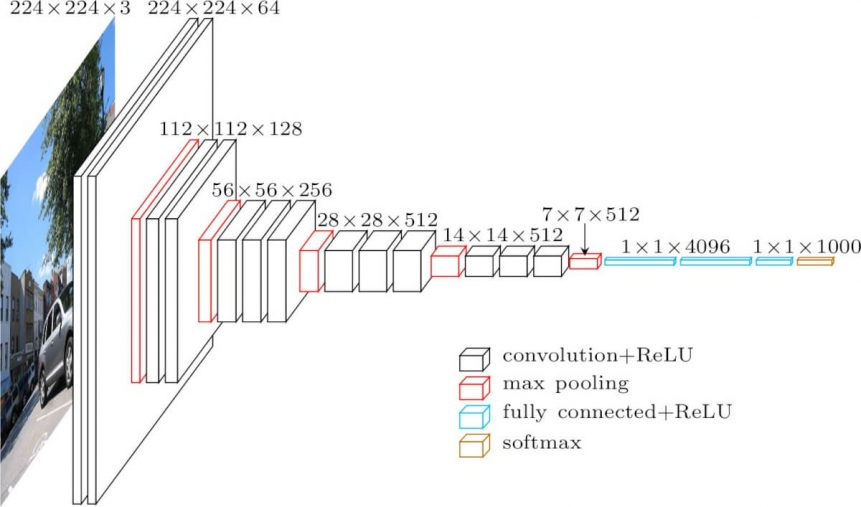

In [ ]:
from typing import List

def vgg_block(
    input_tensor,
    filters: List[int],
    is_training,
    kernel_size=(3, 3),
    strides=(1, 1),
    bn_momentum=0.9,
    name='vgg_block'
):
    with tf.variable_scope(f'{name}', reuse=tf.AUTO_REUSE):
        
        prev_output = input_tensor
        updates = []
        for i, filter in enumerate(filters):
            conv_block_i_output, conv_block_i_updates = conv_block_with_bn(
                prev_output, output_channels=filter,
                is_training=is_training,
                name=f'conv{i+1}',
                kernel_size=kernel_size,
                strides=strides,
                padding='SAME',
                bn_momentum=bn_momentum
            )
            prev_output = conv_block_i_output
            updates += conv_block_i_updates
        
        output = max_pool(
            prev_output,
            kernel_size=(2, 2),
            strides=(2, 2),
            name='pool'
        )
    
    # return tuple: (output, list of updates)
    return output, updates

In [ ]:
class BatchNormNetwork:
    
    def __init__(self):
        self.updates = []
        self.is_training = tf.placeholder(tf.bool, shape=[])
        
    def add_block(self, build_fn):
        output_tensor, output_updates = build_fn()
        
        self.updates.extend(output_updates)
        return output_tensor

In [ ]:
class VGG16(BatchNormNetwork):
    
    def __init__(self, input_tensor, num_classes):
        super().__init__()
        
        self.input_tensor = input_tensor
        self.num_classes = num_classes
        
        self.build_network()
    
    def build_network(self):
        with tf.variable_scope('vgg16', reuse=tf.AUTO_REUSE):
            
            self.vgg_block1 = self.build_vgg_block(
                self.input_tensor,
                output_filters=(64, 64),
                name='vgg_block1'
            )

            self.vgg_block2 = self.build_vgg_block(
                self.vgg_block1,
                output_filters=(128, 128),
                name='vgg_block2'
            )

            self.vgg_block3 = self.build_vgg_block(
                self.vgg_block2,
                output_filters=(256, 256, 256),
                name='vgg_block3'
            )

            self.vgg_block4 = self.build_vgg_block(
                self.vgg_block3,
                output_filters=(512, 512, 512),
                name='vgg_block4'
            )

            self.vgg_block5 = self.build_vgg_block(
                self.vgg_block4,
                output_filters=(512, 512, 512),
                name='vgg_block5'
            )

            self.flatten = flatten(
                self.vgg_block5,
                name='flatten'
            )
            
            self.fc1 = fc_with_relu(
                self.flatten,
                output_neurons=4096,
                name='fc1'
            )

            self.fc2 = fc_with_relu(
                self.fc1,
                output_neurons=4096,
                name='fc2'
            )

            self.fc_final = dense(
                self.fc2,
                output_neurons=self.num_classes,
                name='fc_final'
            )
            
    def build_vgg_block(self, input_tensor, output_filters, name):
        with tf.variable_scope(name, reuse=tf.AUTO_REUSE):
            block = self.add_block(
                lambda: vgg_block(
                            input_tensor,
                            filters=output_filters,
                            is_training=self.is_training,
                            kernel_size=(3, 3),
                            strides=(1, 1),
                            bn_momentum=0.99,
                            name='block'
                        )
            )
        
        return block
    
    def get_trainable_variables(self):
        return tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope='vgg16')
    
    def get_logits(self):
        return self.fc_final

In [ ]:
class LossMeter:
    def __init__(self, network, inputs, labels, name):
        self.network = network
        self.inputs = inputs
        self.labels = labels
        
        self.logits = self.network.get_logits()
        self.name = name
        
        with tf.variable_scope(name, reuse=tf.AUTO_REUSE):
            self.loss = tf.reduce_mean(
                tf.nn.sigmoid_cross_entropy_with_logits(
                    labels=self.labels,
                    logits=self.logits
                )
            )
            
            self.predictions = tf.argmax(self.logits, axis=1)
            self.target = tf.argmax(self.labels, axis=1)
            
            self.metrics = define_metrics(
                f'{name}/metrics/',
                variables={
                    'target': self.target,
                    'predictions': self.predictions,
                    'loss': self.loss
                }
            )
    
            self.optimizer = tf.train.GradientDescentOptimizer(
                learning_rate=0.01
            ).minimize(
                self.loss,
                var_list=self.network.get_trainable_variables()
            )
        
    def reset_metrics(self):
        reset_metrics(f'{self.name}/metrics/train')
        reset_metrics(f'{self.name}/metrics/val')

In [ ]:
tf.reset_default_graph()
sess = tf.InteractiveSession();

/usr/local/lib/python3.7/dist-packages/tensorflow/python/client/session.py:1761: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


In [ ]:
a = tf.placeholder_with_default(np.zeros((10, 224, 224, 3), dtype=np.float32), shape=(None, 224, 224, 3))
b = tf.placeholder_with_default(np.zeros((10, 5), dtype=np.float32), shape=(None, 5))

In [ ]:
net = VGG16(a, num_classes=5)

In [ ]:
loss_meter = LossMeter(net, a, b, name='vgg16')

In [ ]:
def train_VGG16(X_train, X_val, y_train, y_val):

    sess.run(tf.global_variables_initializer())
    sess.run(tf.local_variables_initializer())

    for epoch_num in range(30):
        loss_meter.reset_metrics()
        for X_batch, y_batch in iterate_batches(flowers_x_train, flower_y_train, 10):
            _, _, _, _ = sess.run([
                loss_meter.optimizer,
                loss_meter.metrics['train_update_acc'],
                loss_meter.metrics['train_update_loss'],
                net.updates
            ], feed_dict={
                loss_meter.inputs: X_batch,
                loss_meter.labels: y_batch,
                net.is_training: True
            })
            
            loss_value, accuracy = sess.run([
                loss_meter.metrics['train_acc'],
                loss_meter.metrics['train_loss']
            ])
            # print(loss_value, accuracy)
        
        print(f'Epoch {epoch_num + 1} train [acc, loss]:', sess.run([
            loss_meter.metrics['train_acc'],
            loss_meter.metrics['train_loss']
        ]))
        
        for X_batch, y_batch in iterate_batches(flowers_x_val, flower_y_val, 10, shuffle=False):
            _, _ = sess.run([
                loss_meter.metrics['val_update_acc'],
                loss_meter.metrics['val_update_loss']
            ], feed_dict = {
                loss_meter.inputs: X_batch,
                loss_meter.labels: y_batch,
                net.is_training: False
            })
        print(
            f'Epoch {epoch_num + 1} val [acc, loss]:',
            sess.run([
                loss_meter.metrics['val_acc'], 
                loss_meter.metrics['val_loss']
            ])
        )

In [ ]:
train_VGG16(flowers_x_train, flowers_x_val, flower_y_train, flower_y_val)

Epoch 1 train [acc, loss]: [0.375, 0.4892915]
Epoch 1 val [acc, loss]: [0.3678474, 0.47772366]
Epoch 2 train [acc, loss]: [0.48160762, 0.41135815]
Epoch 2 val [acc, loss]: [0.53678477, 0.42893952]
Epoch 3 train [acc, loss]: [0.53814715, 0.38094965]
Epoch 3 val [acc, loss]: [0.6021798, 0.3661052]
Epoch 4 train [acc, loss]: [0.5623297, 0.3668902]
Epoch 4 val [acc, loss]: [0.5735695, 0.39971685]
Epoch 5 train [acc, loss]: [0.5776567, 0.3581475]
Epoch 5 val [acc, loss]: [0.59945506, 0.39253327]
Epoch 6 train [acc, loss]: [0.60490465, 0.3368089]
Epoch 6 val [acc, loss]: [0.58583105, 0.4265193]
Epoch 7 train [acc, loss]: [0.6120572, 0.3318929]
Epoch 7 val [acc, loss]: [0.6594005, 0.3228957]
Epoch 8 train [acc, loss]: [0.628406, 0.31944427]
Epoch 8 val [acc, loss]: [0.6348774, 0.3711966]
Epoch 9 train [acc, loss]: [0.640327, 0.31116536]
Epoch 9 val [acc, loss]: [0.619891, 0.4178438]
Epoch 10 train [acc, loss]: [0.6648501, 0.2992071]
Epoch 10 val [acc, loss]: [0.58446866, 0.49584126]
Epoch 11 

## Augmentations 

In [ ]:
!pip install -qU albumentations

     |████████████████████████████████| 81kB 5.1MB/s 
     |████████████████████████████████| 37.6MB 79kB/s 
     |████████████████████████████████| 952kB 42.1MB/s 


In [ ]:
import albumentations as A

In [ ]:
transform = A.Compose([
    A.RandomSizedCrop((120, 224), 224, 224, p=0.5),
    A.HorizontalFlip(p=0.2),
    A.VerticalFlip(p=0.3),
    A.RandomBrightnessContrast(p=0.2),
])

In [ ]:
def process_image_augmented(filename):
    img = cv2.resize(cv2.imread(filename), (224, 224))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    transformed = transform(image=img)
    transformed_image = transformed["image"]
    
    return transformed_image / 127.5 - 1.0

In [ ]:
def make_augmented_train_data(num_augmented_copies=3):
    total_x_train_a = []
    total_x_train_a.extend(flowers_x_train)
    total_y_train_a = []
    total_y_train_a.extend(flower_y_train)

    for i in range(num_augmented_copies):
        x_train_a = Parallel(n_jobs=8, verbose=1)(delayed(process_image_augmented)(path) for path in flower_paths_train)
        x_train_a = np.concatenate([np.expand_dims(img, 0) for img in x_train_a])

        total_x_train_a.extend(x_train_a)
        total_y_train_a.extend(flower_y_train)

    return np.array(total_x_train_a), np.array(total_y_train_a)

In [ ]:
flowers_x_train_augmented, flower_y_train_augmented = make_augmented_train_data(num_augmented_copies=2)

[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    2.6s
[Parallel(n_jobs=8)]: Done 920 tasks      | elapsed:    6.0s
[Parallel(n_jobs=8)]: Done 2906 tasks      | elapsed:   13.1s
[Parallel(n_jobs=8)]: Done 2936 out of 2936 | elapsed:   13.3s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.4s
[Parallel(n_jobs=8)]: Done 1200 tasks      | elapsed:    4.5s
[Parallel(n_jobs=8)]: Done 2936 out of 2936 | elapsed:   10.4s finished


## Train models on augmented data

### ResNet

In [ ]:
tf.reset_default_graph()
sess = tf.InteractiveSession();

/usr/local/lib/python3.7/dist-packages/tensorflow/python/client/session.py:1761: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


In [ ]:
a = tf.placeholder_with_default(np.zeros((10, 224, 224, 3), dtype=np.float32), shape=(None, 224, 224, 3))
b = tf.placeholder_with_default(np.zeros((10, 5), dtype=np.float32), shape=(None, 5))

In [ ]:
net = ResNet18(a, num_classes=5)

In [ ]:
loss_meter = LossMeter(net, a, b, name='resnet18')

In [ ]:
%%time
train_ResNet(flowers_x_train_augmented, flowers_x_val, flower_y_train_augmented, flower_y_val)

Epoch 1 train [acc, loss]: [0.5418937, 0.40498808]
Epoch 1 val [acc, loss]: [0.5681199, 0.3680646]
Epoch 2 train [acc, loss]: [0.6671208, 0.29522958]
Epoch 2 val [acc, loss]: [0.5626703, 0.4091759]
Epoch 3 train [acc, loss]: [0.7301317, 0.24946746]
Epoch 3 val [acc, loss]: [0.6689373, 0.30505696]
Epoch 4 train [acc, loss]: [0.7803134, 0.21182223]
Epoch 4 val [acc, loss]: [0.70435965, 0.28009948]
Epoch 5 train [acc, loss]: [0.83503634, 0.16517255]
Epoch 5 val [acc, loss]: [0.5626703, 0.52803594]
Epoch 6 train [acc, loss]: [0.87817895, 0.12582861]
Epoch 6 val [acc, loss]: [0.67711174, 0.40934142]
Epoch 7 train [acc, loss]: [0.92926884, 0.08347112]
Epoch 7 val [acc, loss]: [0.6444142, 0.46796894]
Epoch 8 train [acc, loss]: [0.9445958, 0.06307335]
Epoch 8 val [acc, loss]: [0.64713895, 0.4997159]
Epoch 9 train [acc, loss]: [0.9601499, 0.04993768]
Epoch 9 val [acc, loss]: [0.65258855, 0.49912336]
Epoch 10 train [acc, loss]: [0.96673477, 0.041413426]
Epoch 10 val [acc, loss]: [0.5531335, 0.86

### Inception

In [ ]:
tf.reset_default_graph()
sess = tf.InteractiveSession();

/usr/local/lib/python3.7/dist-packages/tensorflow/python/client/session.py:1761: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


In [ ]:
a = tf.placeholder_with_default(np.zeros((10, 224, 224, 3), dtype=np.float32), shape=(None, 224, 224, 3))
b = tf.placeholder_with_default(np.zeros((10, 5), dtype=np.float32), shape=(None, 5))

In [ ]:
net = InceptionV1Network(a, num_classes=5)

In [ ]:
loss_meter = LossMeterInception(net, a, b, name='inception_v1')

In [ ]:
%%time
train_Inception(flowers_x_train_augmented, flowers_x_val, flower_y_train_augmented, flower_y_val)

Epoch 1 train [acc, loss]: [0.34332424, 0.7299358]
Epoch 1 val [acc, loss]: [0.47002724, 0.6319564]
Epoch 2 train [acc, loss]: [0.5841281, 0.53326887]
Epoch 2 val [acc, loss]: [0.59945506, 0.53543633]
Epoch 3 train [acc, loss]: [0.6428247, 0.47157243]
Epoch 3 val [acc, loss]: [0.66348773, 0.4714439]
Epoch 4 train [acc, loss]: [0.67767936, 0.43778104]
Epoch 4 val [acc, loss]: [0.6825613, 0.43719068]
Epoch 5 train [acc, loss]: [0.71401, 0.40180147]
Epoch 5 val [acc, loss]: [0.6866485, 0.457024]
Epoch 6 train [acc, loss]: [0.72649866, 0.38253608]
Epoch 6 val [acc, loss]: [0.7016349, 0.41545606]
Epoch 7 train [acc, loss]: [0.74296093, 0.3633496]
Epoch 7 val [acc, loss]: [0.69346046, 0.40840498]
Epoch 8 train [acc, loss]: [0.7613533, 0.3369661]
Epoch 8 val [acc, loss]: [0.71253407, 0.4135606]
Epoch 9 train [acc, loss]: [0.7715713, 0.32094595]
Epoch 9 val [acc, loss]: [0.69346046, 0.42402196]
Epoch 10 train [acc, loss]: [0.7758856, 0.31428593]
Epoch 10 val [acc, loss]: [0.70299727, 0.4041932

### VGG-16

In [ ]:
tf.reset_default_graph()
sess = tf.InteractiveSession();

/usr/local/lib/python3.7/dist-packages/tensorflow/python/client/session.py:1761: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


In [ ]:
a = tf.placeholder_with_default(np.zeros((10, 224, 224, 3), dtype=np.float32), shape=(None, 224, 224, 3))
b = tf.placeholder_with_default(np.zeros((10, 5), dtype=np.float32), shape=(None, 5))

In [ ]:
net = VGG16(a, num_classes=5)

In [ ]:
loss_meter = LossMeter(net, a, b, name='vgg16')

In [ ]:
%%time
train_VGG16(flowers_x_train_augmented, flowers_x_val, flower_y_train_augmented, flower_y_val)

Epoch 1 train [acc, loss]: [0.3797684, 0.49259156]
Epoch 1 val [acc, loss]: [0.34196186, 0.5028747]
Epoch 2 train [acc, loss]: [0.49591282, 0.39999703]
Epoch 2 val [acc, loss]: [0.48773843, 0.47967952]
Epoch 3 train [acc, loss]: [0.54904634, 0.3757254]
Epoch 3 val [acc, loss]: [0.52861035, 0.4500472]
Epoch 4 train [acc, loss]: [0.5711853, 0.36205342]
Epoch 4 val [acc, loss]: [0.5871935, 0.41201508]
Epoch 5 train [acc, loss]: [0.57697546, 0.35146827]
Epoch 5 val [acc, loss]: [0.6144414, 0.4021755]
Epoch 6 train [acc, loss]: [0.6192098, 0.32828584]
Epoch 6 val [acc, loss]: [0.53678477, 0.5263863]
Epoch 7 train [acc, loss]: [0.6280654, 0.32223386]
Epoch 7 val [acc, loss]: [0.592643, 0.40288138]
Epoch 8 train [acc, loss]: [0.633515, 0.31847093]
Epoch 8 val [acc, loss]: [0.640327, 0.34520522]
Epoch 9 train [acc, loss]: [0.66076297, 0.3033126]
Epoch 9 val [acc, loss]: [0.64168936, 0.37529626]
Epoch 10 train [acc, loss]: [0.65769756, 0.30444193]
Epoch 10 val [acc, loss]: [0.64850134, 0.365414